In [2]:
import pandas as pd
df = pd.read_csv('encoded_data.csv')

In [11]:
df = df.drop(['id', 'service_type', 'apps'], axis=1)

Undersampling tamamlandı! Yeni veri seti boyutları:
churn
0    668265
1    133653
Name: count, dtype: int64
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 93851, number of negative: 467491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1999
[LightGBM] [Info] Number of data points in the train set: 561342, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167190 -> initscore=-1.605672
[LightGBM] [Info] Start training from score -1.605672

Model Performansı:
                            Accuracy  Recall  Roc_Auc  Precision  F1_Score
LightGBM_adjusted_weight_5    0.6559  0.9382   0.7691     0.3174    0.4743


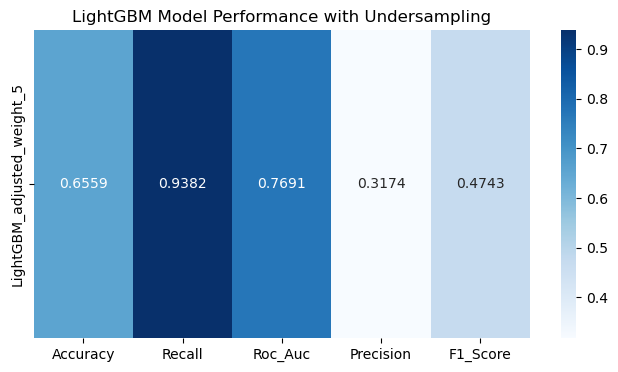

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
from lightgbm import LGBMClassifier

# Hedef değişken
target = "churn"

# Churn olanları ve olmayanları ayır
df_churn = df[df[target] == 1]  # Churn (1) olanlar
df_no_churn = df[df[target] == 0]  # Churn (0) olanlar

# No churn olanlardan churn'un 5 katı kadar örnek alalım (Random değil!)
df_no_churn_sampled = df_no_churn.sample(n=len(df_churn) * 5, random_state=42)

# Yeni veri setini oluştur
df_balanced = pd.concat([df_churn, df_no_churn_sampled])

# Karıştıralım
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Undersampling tamamlandı! Yeni veri seti boyutları:")
print(df_balanced[target].value_counts())

# ---- MODEL EĞİTME AŞAMASI ----
# Model performans skorlarını tutacak listeler
accuracy = []
recall = []
roc_auc = []
precision = []
f1 = []

# Bağımsız ve bağımlı değişkenleri ayır
independent_features = df_balanced.drop(target, axis=1)
dependent_feature = df_balanced[target]

# Kategorik değişkenleri dönüştür (LightGBM için)
for col in independent_features.columns:
    if independent_features[col].dtype == 'object' or independent_features[col].dtype.name == 'category':
        independent_features[col] = independent_features[col].astype('category')

# Veriyi train-test olarak böl
X_train, X_test, y_train, y_test = train_test_split(independent_features, dependent_feature, test_size=0.3, random_state=42)

# LightGBM Modeli oluştur ve eğit
lgbmc = LGBMClassifier(random_state=0, scale_pos_weight=5)
lgbmc.fit(X_train, y_train, categorical_feature='auto', eval_set=(X_test, y_test), feature_name='auto')

# Tahmin yap
y_pred = lgbmc.predict(X_test)

# Metrikleri hesapla ve sakla
accuracy.append(round(accuracy_score(y_test, y_pred), 4))
recall.append(round(recall_score(y_test, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_test, y_pred), 4))
precision.append(round(precision_score(y_test, y_pred), 4))
f1.append(round(f1_score(y_test, y_pred), 4))

# Sonuçları DataFrame'e aktar
model_names = ['LightGBM_adjusted_weight_5']
result_df = pd.DataFrame({'Accuracy': accuracy, 'Recall': recall, 'Roc_Auc': roc_auc, 'Precision': precision, 'F1_Score': f1}, 
                         index=model_names)

# Sonuçları yazdır
print("\nModel Performansı:")
print(result_df)

# Model performansını görselleştir
plt.figure(figsize=(8, 4))
sns.heatmap(result_df, annot=True, cmap='Blues', fmt=".4f")
plt.title("LightGBM Model Performance with Undersampling")
plt.show()

In [13]:
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve

# Modeli eğit
lgbmc = LGBMClassifier(random_state=0, scale_pos_weight=5)
lgbmc.fit(X_train, y_train)  # Modeli eğittik

# Test verisi için olasılıkları al (sadece pozitif sınıf için)
y_probs = lgbmc.predict_proba(X_test)[:, 1]

# Precision-Recall eğrisini hesapla
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# En iyi threshold'u bul (Precision ve Recall'un çarpımını en büyük yapan threshold)
best_threshold = thresholds[(precisions * recalls).argmax()]

print(f"En iyi threshold: {best_threshold}")

# Yeni threshold'u kullanarak tahmin yap
y_pred_adjusted = (y_probs > best_threshold).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Yeni tahminlerle performans ölçümleri
accuracy = accuracy_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)

print(f"Yeni Threshold ({best_threshold}) ile Model Performansı:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 93851, number of negative: 467491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1999
[LightGBM] [Info] Number of data points in the train set: 561342, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167190 -> initscore=-1.605672
[LightGBM] [Info] Start training from score -1.605672
En iyi threshold: 0.44593711941508063
Yeni Threshold (0.44593711941508063) ile Model Performansı:
Accuracy: 0.6529
Precision: 0.3161
Recall: 0.9431
F1 Score: 0.4735


In [16]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Modeli oluşturun ve eğitin
xgb_model = xgb.XGBClassifier(random_state=0, scale_pos_weight=5)
xgb_model.fit(X_train, y_train)

# Tahmin yapın ve performansı değerlendirin
y_pred_xgb = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

print(f"XGBoost Model Performansı:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

import joblib

# Modeli kaydet
joblib.dump(xgb_model, "xgb_model.pkl")
print("Model başarıyla kaydedildi.")

XGBoost Model Performansı:
Accuracy: 0.6652
Precision: 0.3205
Recall: 0.9134
F1 Score: 0.4745
Model başarıyla kaydedildi.


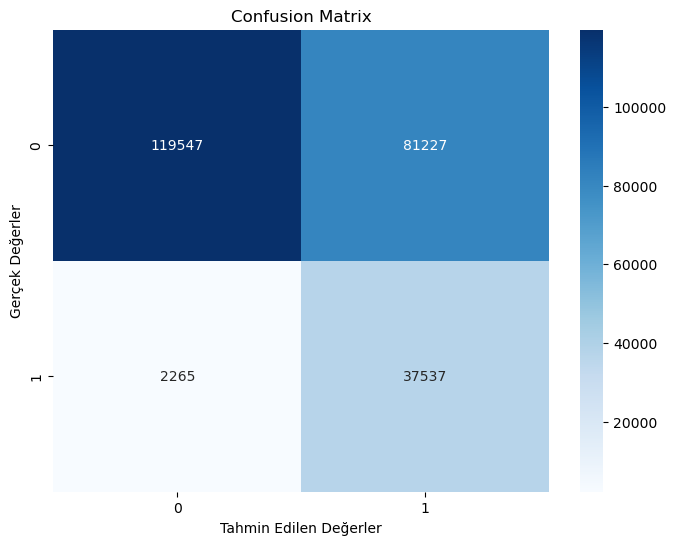

In [15]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix hesapla
cm = confusion_matrix(y_test, y_pred_adjusted)

# Görselleştirme (isteğe bağlı)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Gerçek Değerler")
plt.xlabel("Tahmin Edilen Değerler")
plt.title("Confusion Matrix")
plt.show()

In [3]:
# Hedef değişken
target = "churn"

# Churn olanları ve olmayanları ayır
df_churn = df[df[target] == 1]  # Churn (1) olanlar
df_no_churn = df[df[target] == 0]  # Churn (0) olanlar

# No churn olanlardan churn'un 5 katı kadar örnek alalım (Random değil!)
df_no_churn_sampled = df_no_churn.sample(n=len(df_churn) * 5, random_state=42)

# Yeni veri setini oluştur
df_balanced = pd.concat([df_churn, df_no_churn_sampled])

# Karıştıralım
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced.to_csv("balanced_data.csv", index=False)

In [2]:
import pandas as pd
df = pd.read_csv('balanced_data.csv')
df.head()

,id,age,tenure,service_type,avg_call_duration,data_usage,roaming_usage,monthly_charge,overdue_payments,auto_payment,...,apps_tuple_CuzdanX,apps_tuple_HizliPazar,apps_tuple_IzleGo,heavy_user,bad_payer,unhappy_customer,num_of_apps_used,tenure_category_Loyal,tenure_category_New,tenure_category_Very Loyal
0,f4044d80-c65f-4139-a408-29092a8aa876,21,209.0,Prepaid,71.28000,107.520000,47.45,2461.79,0,0,...,0,0,0,1,0,0,0,0,0,1
1,6e056a92-a0ea-45e9-a63f-b503aa68827b,18,158.0,Prepaid,39.61000,99.986878,3.23,1508.34,0,0,...,0,0,0,1,0,0,0,0,0,1
2,4200478e-227d-4aff-b611-cd6adf650e5e,47,329.0,Postpaid,65.41000,42.190000,49.01,77.09,4,1,...,0,0,0,1,0,0,0,0,0,1
3,d0edd8de-2fdb-48ef-bc2d-ab0f58727335,22,72.0,Postpaid,60.52584,92.130000,37.94,124.86,1,0,...,0,0,0,1,0,0,0,0,0,1
4,c7b68203-2ec7-4487-a475-2efcb9c47367,32,210.0,Postpaid,110.50000,97.910000,25.66,42.47,5,0,...,0,0,0,1,1,0,0,0,0,1


In [8]:
df["apps"].head

<bound method NDFrame.head of 0                    []
1         ['Konuşalım']
2         ['Konuşalım']
3         ['Konuşalım']
4                    []
              ...      
801913               []
801914               []
801915               []
801916    ['Konuşalım']
801917               []
Name: apps, Length: 801918, dtype: object>